### Solución **Lanchain**

In [2]:
import getpass
import os

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [3]:
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

#### A. Indexar

In [4]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = ChatOpenAI(model='gpt-4o-mini')
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = InMemoryVectorStore(embeddings)

In [5]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader, PyPDFLoader, CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS  # Usa el vector store FAISS como ejemplo

# Función para obtener el loader correspondiente según la extensión del archivo
def get_loader(file_extension):
    if file_extension == 'txt':
        return TextLoader
    elif file_extension == 'pdf':
        return PyPDFLoader
    elif file_extension == 'csv':
        return CSVLoader
    else:
        raise ValueError(f"Formato no soportado: {file_extension}")

# Definir directorio donde se encuentran los archivos
DIRECTORY_PATH = './data'

# Extensiones de archivo y sus loaders correspondientes
SUPPORTED_FILE_TYPES = [
    (".txt", TextLoader),
    (".pdf", PyPDFLoader),
    (".csv", CSVLoader)
]

# Crear una lista para almacenar los loaders configurados
loaders = []

# Configurar loaders para cada tipo de archivo soportado
for extension, loader_class in SUPPORTED_FILE_TYPES:
    loader = DirectoryLoader(
        path=DIRECTORY_PATH,
        glob=f"**/*{extension}",
        loader_cls=loader_class
    )
    loaders.append(loader)

# Lista para almacenar los documentos cargados
documents = []

# Cargar documentos usando cada loader
for loader in loaders:
    loaded_documents = loader.load()
    documents.extend(loaded_documents)

# Imprimir información básica de los documentos cargados
print(f"Se cargaron {len(documents)} documentos.")

# Dividir documentos en fragmentos con RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Tamaño de cada fragmento (en caracteres)
    chunk_overlap=200,  # Superposición entre fragmentos (en caracteres)
    add_start_index=True  # Agregar el índice de inicio en el documento original
)

# Dividir los documentos en fragmentos más pequeños
all_splits = text_splitter.split_documents(documents)

print(f"Los documentos se dividieron en {len(all_splits)} fragmentos.")

# Agregar los fragmentos al vector store
document_ids = vector_store.add_documents(documents=all_splits)

# Imprimir los primeros tres IDs de documentos añadidos al vector store
print("Primeros 3 document IDs añadidos al vector store:", document_ids[:3])


Se cargaron 175 documentos.
Los documentos se dividieron en 769 fragmentos.
Primeros 3 document IDs añadidos al vector store: ['f9a6152e-fd89-452d-97e7-99e35ebb17db', '2ef9cd5c-5489-43a3-b401-82af705caaa6', '01d95bf8-05cf-40ee-a8ff-ecaf78c97337']


#### 2. Retrieval and Generation

In [6]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [7]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}

def generate(state: State):
    content = "\n\n".join(doc.page_content for doc in state['context'])
    messages = prompt.invoke({"question": state['question'], "context": content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [8]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])

graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

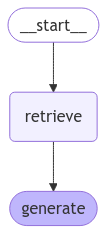

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
result = graph.invoke({"question": "Que datos tienes?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='736f7fa1-f076-43b7-826f-0329c9e7cf95', metadata={'source': 'data/Dialnet-LasPreferenciasCiudadanasHaciaAlternativasDePoliti-9416658.pdf', 'page': 10, 'start_index': 2390}, page_content='— «Edad 2»: edad al cuadrado.\n— «Mujer»: variable discreta que toma un va-\nlor de 1 si el entrevistado es una mujer, y 0 \nen otro caso.\n— «Casado» (o viviendo en pareja): variable \ndiscreta que toma un valor de 1 si el en-\ntrevistado está casado o convive de ma-\nnera estable con una pareja, y 0 en otro \ncaso.\n— «Gran ciudad»: variable discreta que \ntoma un valor de 1 si el entrevistado'), Document(id='0d209551-7f87-4c2e-a6a6-f4f1ba5cfbfd', metadata={'source': 'data/Dialnet-LasPreferenciasCiudadanasHaciaAlternativasDePoliti-9416658.pdf', 'page': 10, 'start_index': 1591}, page_content='Mujer 3.097   0     1     0,520     0,50 –0,06 1,00\nCasado 3.097   0     1     0,570     0,49 –0,30 1,09\nGran ciudad 3.097   0     1     0,340     0,22 0,68 1,46\nRural 3.097   0     1    

In [11]:
result = graph.invoke({"question": "Listame los articulos que tengas disponible"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='8b3f0e08-7a34-4d6e-a7c3-cbd1fef300e2', metadata={'source': 'data/Dialnet-ElNivelEducativoDeLaPoblacionResidenteEnEspanaYSus-9416654.pdf', 'page': 5, 'start_index': 1620}, page_content='valores centrales del índice. En la tabla\xa0 1 \nse expone la frecuencia de valores de las \ncategorías del índice así agrupadas, tanto \noriginales como estimados, una vez apli-\ncado el coeficiente de ponderación reco-\nmendado de la ESE.'), Document(id='026fe354-9ffd-48d1-8ed7-fa5c0d978ccd', metadata={'source': 'data/Dialnet-ElNivelEducativoDeLaPoblacionResidenteEnEspanaYSus-9416654.pdf', 'page': 10, 'start_index': 1605}, page_content='30\n77\n25,4\n65,3\n4,4 118\nIndiferente\nA favor\nTotal\n Nodo 6\nCategoría % n\nEn contra 16,7 12\n15\n45\n20,8\n62,5\n2,7 72\nIndiferente\nA favor\nTotal\n Nodo 5\nCategoría % n\nEn contra 32,5 87\n94\n87\n35,1\n32,5\n10,0 268\nIndiferente\nA favor\nTotal\n Nodo 4\nCategoría % n\nEn contra 22,2 157\n268\n282\n37,9\n26,4 707\nIndiferente\nA fav

### 3. Query analysis

In [12]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'data/z_resumen.txt', 'start_index': 0, 'section': 'beginning'}

In [14]:
from langchain_core.vectorstores import InMemoryVectorStore

_ = vector_store.add_documents(all_splits)

In [15]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [16]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieve_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieve_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

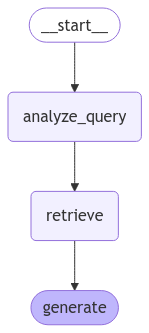

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
for step in graph.stream(
    {"question": "¿Qué información tienes disponible?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")


{'analyze_query': {'query': {'query': 'información disponible', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='e8a86d35-a383-4bf7-9bfd-4c1defb3878b', metadata={'source': 'data/Dialnet-AsociacionismoCapitalSocialYGeneroEnLaSociedadEspa-9416660.pdf', 'page': 0, 'start_index': 2364, 'section': 'beginning'}, page_content='cis/reis.186.143-158)\nLa versión en inglés de este artículo puede consultarse en http://reis.cis.es\nLoreto Vázquez-Chas: Universidade da Coruña | loreto.vazquez@udc.es\nJosé Atilano Pena-López: Universidade da Coruña | atilano.pena@udc.es'), Document(id='50c2c3e1-a68e-4f88-a594-3caab1d0a04f', metadata={'source': 'data/Dialnet-AsociacionismoCapitalSocialYGeneroEnLaSociedadEspa-9416660.pdf', 'page': 0, 'start_index': 2364, 'section': 'beginning'}, page_content='cis/reis.186.143-158)\nLa versión en inglés de este artículo puede consultarse en http://reis.cis.es\nLoreto Vázquez-Chas: Universidade da Coruña | loreto.vazquez@udc.es\nJosé A

In [22]:
for step in graph.stream(
    {"question": "¿Listame los articulos disponibles?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")


{'analyze_query': {'query': {'query': 'artículos disponibles', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='c4d1669b-32ac-4648-9c44-5cfbf541ef0e', metadata={'source': 'data/Dialnet-ElNivelEducativoDeLaPoblacionResidenteEnEspanaYSus-9416654.pdf', 'page': 16, 'start_index': 0, 'section': 'beginning'}, page_content='Carlos Carvajal-Martín 41\nReis. Rev.Esp.Investig.Sociol. ISSN-L: 0210-5233. N.º 186, Abril - Junio 2024, pp.\xa025-42\nSocieties: Public Views and Perceptions in a Cross-\nnational Comparative Perspective». International \nJournal of Comparative Sociology, 49(1): 5-29.\nValdés, Manuel T. (2020). «Efectos primarios y secunda-\nrios del origen social en la transición a la educación \nposobligatoria en España» /«Primary and Secon-\ndary Effects of Social Origin in theTransition to Post-\nCompulsory Education in Spain». Revista Española \nde Investigaciones Sociológicas, 171: 125-144.\nWaal, Jeroen van der; Achterberg, Peter; Houtman, \nDick